# Predicting Safe Loans with Classification Trees
This demo uses real data from the [Lending Club](https://www.lendingclub.com/). The Lending Club is an American peer-to-peer lending company, headquartered in San Francisco, California.

**References:**\
[Download data](https://www.kaggle.com/wendykan/lending-club-loan-data#loan.csv)\
[Classification Trees in Scikit-Learn Documentation](https://scikit-learn.org/stable/modules/tree.html#tree)


In [17]:
# Import libraries for handling data
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import libraries for implementing machine learning 
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier


## 1. Load the Lending Club dataset

In [2]:
# Load data
loans = pd.read_csv("lending-club-data.csv", low_memory=False)

print("Number records:", loans.shape[0])
print("Number features:", loans.shape[1])


Number records: 122607
Number features: 68


In [3]:
# Explore a few records
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## 2. Data Exploration & Preprocessing

In [4]:
# Explore all columns
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

### Transforming the output

The output (also called target or label) column of the dataset that we are interested in is called bad_loans. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this consistent with the slides, we reassign the target to be:

- +1 as a safe loan
- -1 as a risky (bad) loan

In [5]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

#loans = loans.remove_column('bad_loans')
loans = loans.drop('bad_loans', axis=1)

### Extracting a subset of the features for building the classification model

In [6]:
PREDICTORS = ['grade',                   # grade of the loan (quality score based on the borrower's credit history)
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day (payments not made on time)
           ]

RESPONSE = 'safe_loans'

loans = loans[PREDICTORS + [RESPONSE]]

In [7]:
loans.head(2)

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.0,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1


### Visualizing distribution of safe_loans column

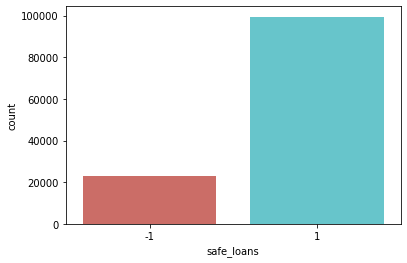

In [10]:
sns.countplot(x='safe_loans', data=loans, palette='hls')
plt.show()

In [11]:
safe_loans_raw = loans[loans[RESPONSE] == +1]
risky_loans_raw = loans[loans[RESPONSE] == -1]

print ("Percentage of safe loans  : {0:.2f}%".format(len(safe_loans_raw)/float(len(loans)) * 100)) 
print ("Percentage of risky loans : {0:.2f}%".format(len(risky_loans_raw)/float(len(loans)) * 100)) 

Percentage of safe loans  : 81.12%
Percentage of risky loans : 18.88%


The distrubtion above indicates the output variable suffers from class imbalance (there are a disproportionate ratio of safe loans versus risky loans). Classification trees are prone to create biased trees if there is class imbalance. Thus, it is recommended to balance the dataset prior to fitting with a classification tree.

In [12]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

print("The ratio of risky loans to safe loans is:", percentage)

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans = risky_loans.append(safe_loans)

The ratio of risky loans to safe loans is: 0.2327639080205516


In [13]:
print ("Percentage of safe loans                 :", len(safe_loans) / float(len(loans)))
print ("Percentage of risky loans                :", len(risky_loans) / float(len(loans)))
print ("Total number of loans in our new dataset :", len(loans))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46300


### Visualizing distribution of safe_loans (after undersampling)

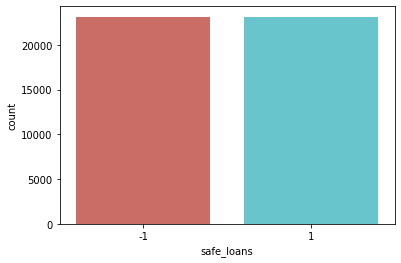

In [14]:
sns.countplot(x='safe_loans', data=loans, palette='hls')
plt.show()

## Visualizing distribution of safe_loans across grade

Text(0, 0.5, 'Frequency of Loans')

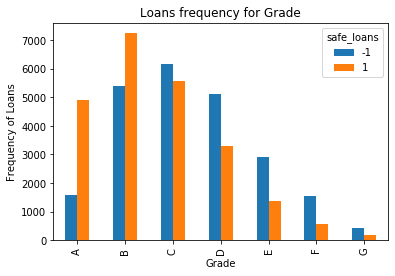

In [15]:
pd.crosstab(loans.grade, loans.safe_loans).plot(kind='bar')
plt.title('Loans frequency for Grade')
plt.xlabel('Grade')
plt.ylabel('Frequency of Loans')

## Visualizing distribution of safe_loans across term

Text(0, 0.5, 'Frequency of Loans')

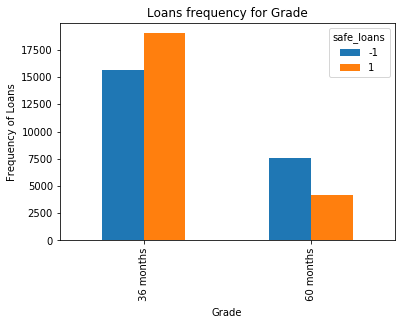

In [16]:
pd.crosstab(loans.term, loans.safe_loans).plot(kind='bar')
plt.title('Loans frequency for Grade')
plt.xlabel('Grade')
plt.ylabel('Frequency of Loans')

#loans.total_rec_late_fee.head(20)

### Transforming categorical features into numeric 

Scikit-learn do not accept categorical features (i.e., features with non-numeric values). The one hot encoding is a mechanism for transforming categorical features into numeric ones. One hot encoding creates a binary column for each value in the categorical feature.

In [53]:
# Identify categorical features
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)

# Transform each categorical feature into numeric features
for feature in categorical_variables:
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature)
    
    # Remove the categorical feature and add the numeric features
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]

In [54]:
print (loans.head(2))        
print (loans.columns)

   short_emp  emp_length_num   dti  last_delinq_none  last_major_derog_none  \
1          1               1  1.00                 1                      1   
6          0               5  5.55                 1                      1   

   revol_util  total_rec_late_fee  safe_loans  grade_A  grade_B  ...  \
1         9.4                 0.0          -1        0        0  ...   
6        32.6                 0.0          -1        0        0  ...   

   purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
1              0                       0                0               0   
6              0                       0                0               0   

   purpose_other  purpose_small_business  purpose_vacation  purpose_wedding  \
1              0                       0                 0                0   
6              0                       1                 0                0   

   term_ 36 months  term_ 60 months  
1                0                1  

## 4. Data Partition

In [55]:
# Prepare input and output for the algorithm
Y = loans[RESPONSE]
X = loans.drop(RESPONSE, axis=1)

### Partioning the data into training and validation sets

In [56]:
 X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.4, random_state=0)

## 5. Learning a classification tree classifier

In [60]:
# Specify depth of the tree as a parameter
decision_tree_model = DecisionTreeClassifier(max_depth=6)

# Learn classification tree using the training partition
decision_tree_model = decision_tree_model.fit(X_train, y_train)

In [61]:
# Display accuracy
decision_tree_model.score(X_train, y_train)

0.640856731461483

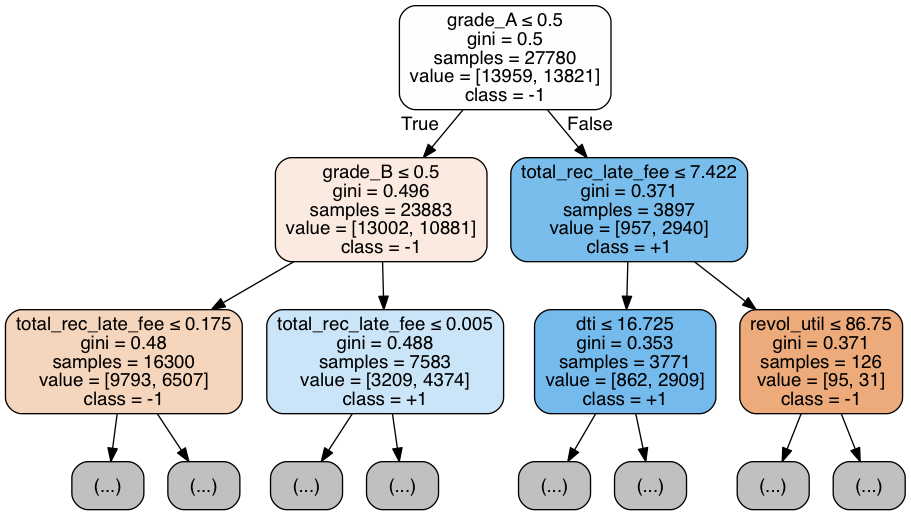

In [62]:
from sklearn import tree
import graphviz 
from os import system

dot_data = tree.export_graphviz(
    decision_tree_model,
    out_file='classification_tree.dot',
    feature_names=X.columns,
    max_depth=2,
    class_names=['-1','+1'],  
    filled=True, 
    rounded=True,  
    special_characters=True) 
system("dot -Tpng classification_tree.dot -o classification_tree.png")

from IPython.display import Image
Image(filename='classification_tree.png')

## 6. Comparing classification trees

### Learning another classifier with a deeper depth


In [142]:
big_decision_tree_model = DecisionTreeClassifier(max_depth=10)

# Learn classification tree using the training partition
big_decision_tree_model = big_decision_tree_model.fit(X_train, y_train)

In [143]:
# Display accuracy
big_decision_tree_model.score(X_train, y_train)

0.6690424766018719

### Detecting Overfitting: Comparing the two models using the validation parition

In [144]:
# Calculate score using training partition
decision_tree_model_train_score = decision_tree_model.score(X_train, y_train)
big_decision_tree_model_train_score = big_decision_tree_model.score(X_train, y_train)

# Calculate score using validation partition
decision_tree_model_val_score = decision_tree_model.score(X_validation, y_validation)
big_decision_tree_model_val_score = big_decision_tree_model.score(X_validation, y_validation)


### Scores using Training Partition

In [145]:
print("Classification Trees with depth=6:", decision_tree_model_train_score)
print("Classification Trees with depth=10:", big_decision_tree_model_train_score)


Classification Trees with depth=6: 0.640856731461483
Classification Trees with depth=10: 0.6690424766018719


### Scores using Validation Partition

In [146]:
print("Classification Trees with depth=6:", decision_tree_model_val_score)
print("Classification Trees with depth=10:", big_decision_tree_model_val_score)


Classification Trees with depth=6: 0.6281857451403887
Classification Trees with depth=10: 0.6201403887688985


Learning a tree with depth=10 creates an over-complex trees that do not generalise the data well. This is an example of overfitting. There are several mechanisms that can automatically identify an optimal depth (e.g., pruning). However, scikit-learn does not support them. Thus, we need to tune the parameters of the algorithm, such as the maximum depth, to avoid this problem. **When tuning the parameters to improve the performance of a model, it is imperative to assess the accuracy of each model using the validation partition.**

